In [6]:
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import os
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import math
import torch.nn.functional as F

'''d_model, n_heads, n_layers, n_classes, dropout_prob=0.1
Classification task of cat or dog images. Images will be 128 by 128 but embedded to 16 by 16 patches, each with 3 colors rgb and 8 by 8 pixels.
--With dysfunctional CLS (First patch classification token)--
75% Accuracy 20 epochs, 16, 20, 4, 2, 2, 0.1 = 21k Parameters
No progress, 50% acc 5 epochs, 8, 48, 6, 4, 2, 0.1 = 122k Parameters
No progress, 50% acc 5 epochs, 16, 40, 4, 4, 2, 0.1 = 102k Parameters
No progress, 50% acc 15 epochs, 16, 20, 4, 4, 2, 0.1 = 30k parameters

--With full feature flatten at the end--
79% 20 epochs, 16, 20, 4, 2, 2, 0.1 = 89k Parameters
8, 48, 6, 4, 2, 0.1 = 171k Parameters

--With official PyTorch encoder
No progress, 50% acc 5 epochs 8, 48, 6, 4, 2, 0.1 = 171k Parameters

--Patch size 3 instead of 16, .0001 LR
Little progress 67% 10 epochs, 16, 20, 4, 2, 2, 0.1 = 116k Parameters

--Patch size 4 instead of 16
62.5% 10 epochs, 12, 3, 2, 2, 0.1 = 41k Parameters

--Patch size 3 instead of 16, resolution 64x64 instead of 128 .0003 LR
62.5% 10 epochs, 12, 3, 2, 2, 0.1 = 20k

--Patch size 16, resolution 128x128 .0003 LR, 1500 images
64.3% acc 15 epochs,20, 4, 2, 2, 0.1 = 34k Parameters
--11900 images
67% accuracy 15 epochs,20, 4, 2, 2, 0.1 = 34k Parameters
--500 images, official Vit Arch
-64% acc 15 epochs,  16 patches 128 resolution 2.5M Parameters
model = ViT(
    image_size = targetXYResolution,
    patch_size = 16,
    num_classes = 2,
    dim = 256,
    depth = 3,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

--11900 images, official Vit Arch
-74% acc 15 epochs,  16 patches 128 resolution, 2.5M Parameters
model = ViT(
    image_size = targetXYResolution,
    patch_size = 16,
    num_classes = 2,
    dim = 256,
    depth = 3,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

--500 images
58% acc 15 epochs 62k parameters
model = ViT(
    image_size = targetXYResolution,
    patch_size = 16,
    num_classes = 2,
    dim = 20,
    depth = 2,
    heads = 4,
    mlp_dim = 32,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

--11900 images
68% acc 15 epochs 62k parameters
model = ViT(
    image_size = targetXYResolution,
    patch_size = 16,
    num_classes = 2,
    dim = 20,
    depth = 2,
    heads = 4,
    mlp_dim = 32,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

--500 images
% acc 15 epochs 53M parameters
model = ViT(
    image_size = targetXYResolution,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

--11900 images
6 acc 15 epochs 53M parameters
model = ViT(
    image_size = targetXYResolution,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
'''

# Desired size
target_width, target_height = 128, 128
patchXY=16
patchResolutionX = int(target_width/patchXY) #16 patches -> 3x8x8
patchResolutionY = int(target_height/patchXY)
class SemanticEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.fc1 = nn.Linear(3 * patchResolutionX * patchResolutionY, d_model)

    def forward(self, x):  # BATCHxHxWxC
        semanticTensor = torch.zeros(x.size(0), patchXY, patchXY, self.d_model, device=x.device)
        for i in range(patchXY):
            for j in range(patchXY):
                patchFlatTensor = x[:, i * patchResolutionX:(i + 1) * patchResolutionX, j * patchResolutionY:(j + 1) * patchResolutionY, :].reshape(x.size(0), -1)  # BATCHxHxWxC -> BATCHxflat
                patchFlatTensor = self.fc1(patchFlatTensor)
                semanticTensor[:, i, j, :] = patchFlatTensor
        return semanticTensor  # returns batch-dimension x 16 x 16 x thought_vector

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout_prob=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(patchXY * patchXY).view(patchXY, patchXY).unsqueeze(-1).to(device)

        # Calculate div_term for sinusoidal encoding
        exp_term = torch.arange(0, d_model, 2).float().to(device)
        div_term = torch.exp(exp_term * (-math.log(10_000.0) / d_model)).to(device)

        # Initialize the positional encoding matrix
        pe = torch.zeros(patchXY, patchXY, d_model, device=device)

        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # Constant tensor buffer which calls the position encoding for each element, add batch dimension

    def forward(self, x):  # B x H x W x S
        x = x + self.pe  # B x H x W x (Semantic + Position)
        return self.dropout(x)

class ImageEncoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, n_classes, dropout_prob=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = SemanticEncoding(d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout_prob)

        # Define the encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model*4,
            dropout=dropout_prob
        )

        # Define the TransformerEncoder with multiple layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(patchXY*patchXY*d_model)
        self.fc = nn.Linear(patchXY*patchXY*d_model, n_classes)

    def forward(self, x):  # Start: B x H x W x C
        # print(f'Start: {x.shape}')
        x = self.embedding(x) # -> B x PatchX x PatchY x E
        # print(f'After embedding: {x.shape}')
        x = self.pos_encoding(x) # -> B x PatchX x PatchY x E+P
        # print(f'After position: {x.shape}')
        x = x.view(x.size(0), patchXY * patchXY, self.d_model) 
        x = x.transpose(1, 0) # -> PatchXY*PatchXY x B x E+P
        # print(f'Before Transformers: {x.shape}')
        x = self.transformer_encoder(x) # -> PatchXY*PatchXY x B x Context        
        # print(f'After Transformers: {x.shape}')
        x = x.transpose(1, 0)
        # print(f'After Transformers transpose: {x.shape}')
        x = x.reshape(x.size(0), -1) # -> B x PatchXY*PatchXY*Context
        # print(f'After weird shape: {x.shape}')
        x = self.ln(x) # -> B x PatchXY*PatchXY*Context(normalized)
        x = self.fc(x) # PatchXY*PatchXY*Context(normalized) -> 2
        return x

def process_image(image_path):
    global target_width, target_height
    # Load image
    img = Image.open(image_path).convert('RGB')

    # Resize image preserving aspect ratio
    img.thumbnail((target_width, target_height))

    # Create a new image with black background
    new_img = Image.new('RGB', (target_width, target_height))
    width, height = img.size

    # Calculate positioning for centering the image
    left = (target_width - width) // 2
    top = (target_height - height) // 2
    new_img.paste(img, (left, top))

    return new_img, new_img

def images_to_tensor(directory, a, b, return_images=False):
    tensor_list = []
    image_list = []  # To store PIL images for visualization
    file_list = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))][a:b]
    for filename in tqdm(file_list, desc="Processing images", unit="images"):
        file_path = os.path.join(directory, filename)
        try:
            processed_img, original_img = process_image(file_path)
            img_tensor = torch.from_numpy(np.array(processed_img))
            # check_image_colors(img_tensor)
            img_tensor = img_tensor.to(torch.float32) / 255 # HxWxC
            tensor_list.append(img_tensor)
            if return_images:
                image_list.append(original_img)  # Append original image
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    tensors = torch.stack(tensor_list)
    return (tensors, image_list) if return_images else tensors

Processing images: 100%|██████████| 100/100 [00:00<00:00, 344.14images/s]


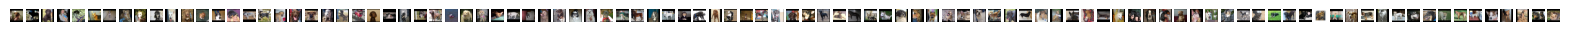

In [7]:
import matplotlib.pyplot as plt

start, finish =2000, 2100
# Load the images and return both tensors and original images for display
data, original_images = images_to_tensor('PetImages/Dog', start, finish, return_images=True)

# Display the images using matplotlib
fig, axes = plt.subplots(1, finish-start, figsize=(20, 4))  # Adjust subplot parameters as needed
for i, img in enumerate(original_images):
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
plt.show()

In [8]:
# Specify the directory containing the images
cats = 'PetImages/Cat'
dogs = 'PetImages/Dog'

# Convert images to a tensor
cats_tensor = images_to_tensor(cats, 0, 11999)
dogs_tensor = images_to_tensor(dogs, 0, 11999)
cats_tensorVal = images_to_tensor(cats, 12000, 12300)
dogs_tensorVal = images_to_tensor(dogs, 12000, 12300)

print(cats_tensor.shape)  # This should print: torch.Size([N, 3, 500, 500]), N is the number of processed images
print(dogs_tensor.shape)  # This should print: torch.Size([N, 3, 500, 500]), N is the number of processed images

# Labels (0 for cats, 1 for dogs)
cats_labels = torch.zeros(cats_tensor.size(0))
dogs_labels = torch.ones(dogs_tensor.size(0))
cats_labelsVal = torch.zeros(cats_tensorVal.size(0))
dogs_labelsVal = torch.ones(dogs_tensorVal.size(0))

# Combine datasets
features = torch.cat([cats_tensor, dogs_tensor], dim=0)
labels = torch.cat([cats_labels, dogs_labels], dim=0)
featuresVal = torch.cat([cats_tensorVal, dogs_tensorVal], dim=0)
labelsVal = torch.cat([cats_labelsVal, dogs_labelsVal], dim=0)

# Create a dataset and data loader
dataset = TensorDataset(features, labels) # the first dimension is the data index
datasetVal = TensorDataset(featuresVal, labelsVal)
#delete cats and dogs tensor here
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)
data_loaderVal = DataLoader(datasetVal, batch_size=10)
del cats_tensor
del dogs_tensor
del features
del labels
del cats_tensorVal
del dogs_tensorVal
del featuresVal
del labelsVal

Processing images: 100%|██████████| 300/300 [00:00<00:00, 350.87images/s]


torch.Size([1500, 128, 128, 3])
torch.Size([1500, 128, 128, 3])


In [ ]:
model = ImageEncoder(20, 4, 2, 2, 0.1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

In [9]:
# Training loop
epochs = 15

for epoch in range(epochs):
    model.train()
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()  # CrossEntropyLoss expects targets as long (integer) type
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # Use raw logits from the model
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    model.eval()
    n_correct = 0.
    n_total = 0.
    for inputs, targets in data_loaderVal:
        inputs = inputs.to(device)
        targets = targets.to(device).long()
        outputs = model(inputs)
        _, prediction = torch.max(outputs, dim=1)
        n_correct += (prediction == targets).sum().item()
        n_total += targets.size(0)
    print(f'Epoch {epoch+1}, Val Accuracy: {n_correct / n_total}')

# Save the model if needed
torch.save(model.state_dict(), 'simple_transformer_model.pth')

Epoch 1, Loss: 0.6484230160713196
Epoch 1, Val Accuracy: 0.51
Epoch 2, Loss: 0.6620664596557617
Epoch 2, Val Accuracy: 0.5666666666666667
Epoch 3, Loss: 0.7128649950027466
Epoch 3, Val Accuracy: 0.635
Epoch 4, Loss: 0.8374041318893433
Epoch 4, Val Accuracy: 0.5833333333333334
Epoch 5, Loss: 0.6302973031997681
Epoch 5, Val Accuracy: 0.5433333333333333
Epoch 6, Loss: 0.6494866013526917
Epoch 6, Val Accuracy: 0.6283333333333333
Epoch 7, Loss: 0.706785261631012
Epoch 7, Val Accuracy: 0.6283333333333333
Epoch 8, Loss: 0.6987832188606262
Epoch 8, Val Accuracy: 0.6433333333333333
Epoch 9, Loss: 0.8699430227279663
Epoch 9, Val Accuracy: 0.5783333333333334
Epoch 10, Loss: 0.6937633752822876
Epoch 10, Val Accuracy: 0.6266666666666667
Epoch 11, Loss: 0.6258798837661743
Epoch 11, Val Accuracy: 0.6333333333333333
Epoch 12, Loss: 0.5856606364250183
Epoch 12, Val Accuracy: 0.62
Epoch 13, Loss: 0.6998797655105591
Epoch 13, Val Accuracy: 0.62
Epoch 14, Loss: 0.5999926924705505
Epoch 14, Val Accuracy: 0

In [10]:
# Initialize and load the model
model = ImageEncoder(20, 4, 2, 2, 0.1).to(device)
# model.load_state_dict(torch.load('simple_transformer_model.pth'))
data = data.to(device)
model.eval()

# Calculate and print the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

with torch.inference_mode():
    output = model(data)
    _, prediction = torch.max(output, dim=1) # batch, prediction
    print(prediction)

Total number of parameters: 34462
tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1], device='cuda:0')
